In [1]:
from statsmodels.stats.diagnostic import het_arch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import ARX, FIGARCH
import warnings
warnings.filterwarnings('ignore')

# 1

Best ARMA model: ARMA(0, 0, 3) with AIC: -19605.529408445313
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &      Return      & \textbf{  No. Observations:  } &    4507     \\
\textbf{Model:}                  &  ARIMA(0, 0, 3)  & \textbf{  Log Likelihood     } &  9807.765   \\
\textbf{Date:}                   & Fri, 28 Feb 2025 & \textbf{  AIC                } & -19605.529  \\
\textbf{Time:}                   &     12:39:46     & \textbf{  BIC                } & -19573.462  \\
\textbf{Sample:}                 &        0         & \textbf{  HQIC               } & -19594.231  \\
\textbf{}                        &      - 4507      & \textbf{                     } &             \\
\textbf{Covariance Type:}        &       opg        & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\m

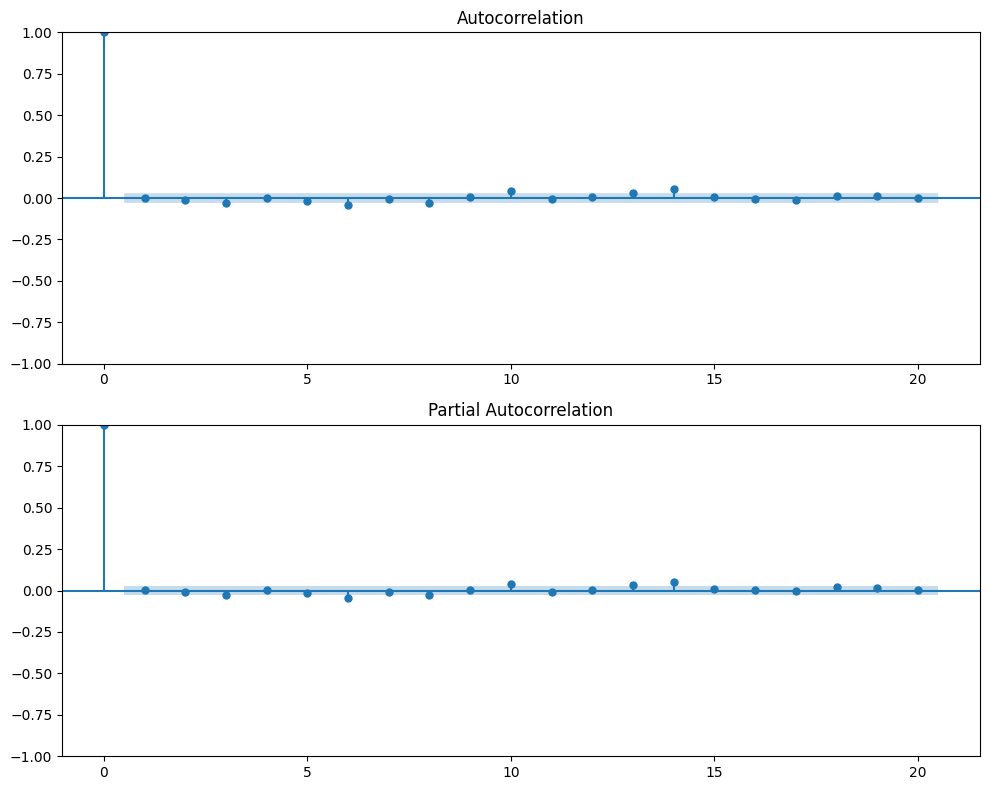

In [2]:
gas = pd.read_csv('gasolineret.csv')
gas['Date'] = pd.to_datetime(gas['Date'])
gas.set_index('Date', inplace=True)

gas_returns = gas['Return']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(gas_returns.dropna(), lags=20, ax=ax1)
sm.graphics.tsa.plot_pacf(gas_returns.dropna(), lags=20, ax=ax2)
plt.tight_layout()

best_aic = np.inf
best_order = None
max_ar = 3
max_ma = 3

for p in range(max_ar + 1):
    for q in range(max_ma + 1):
        if p == 0 and q == 0:
            continue 
        try:
            model = ARIMA(gas_returns.dropna(), order=(p, 0, q))
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, 0, q)
                best_model = results
        except:
            continue

print(f"Best ARMA model: ARMA{best_order} with AIC: {best_aic}")
print(best_model.summary().as_latex())

# 2

Ljung-Box Test on Residuals:
\begin{tabular}{lrr}
\toprule
 & lb_stat & lb_pvalue \\
\midrule
1 & 0.004035 & 0.949348 \\
2 & 0.023130 & 0.988502 \\
3 & 0.023171 & 0.999068 \\
4 & 0.023171 & 0.999933 \\
5 & 1.142103 & 0.950310 \\
6 & 8.894291 & 0.179611 \\
7 & 9.079874 & 0.246972 \\
8 & 12.551090 & 0.128257 \\
9 & 12.620791 & 0.180529 \\
10 & 20.580949 & 0.024213 \\
\bottomrule
\end{tabular}


Ljung-Box Test on Squared Residuals:
\begin{tabular}{lrr}
\toprule
 & lb_stat & lb_pvalue \\
\midrule
1 & 319.352371 & 0.000000 \\
2 & 392.727698 & 0.000000 \\
3 & 649.803186 & 0.000000 \\
4 & 709.771928 & 0.000000 \\
5 & 812.289201 & 0.000000 \\
6 & 841.152911 & 0.000000 \\
7 & 857.797019 & 0.000000 \\
8 & 867.738854 & 0.000000 \\
9 & 879.774545 & 0.000000 \\
10 & 883.774629 & 0.000000 \\
\bottomrule
\end{tabular}


ARCH-LM Test p-value: 4.1329892296863164e-116


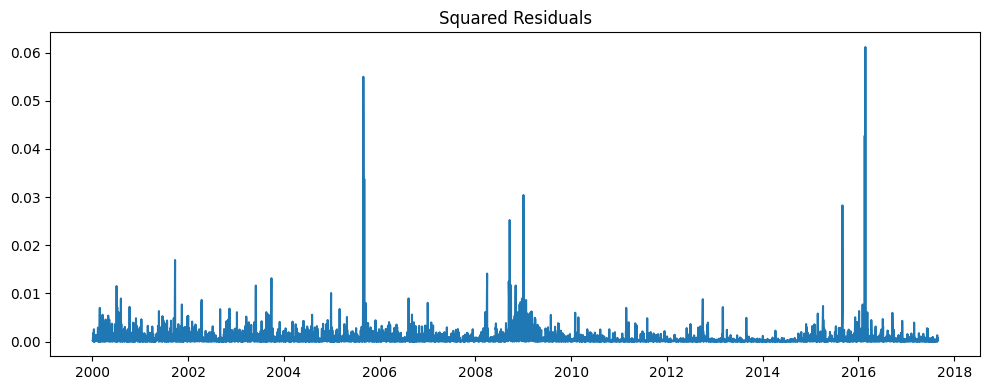

In [3]:
residuals = best_model.resid

ljung_box : pd.DataFrame = acorr_ljungbox(residuals, lags=10)
print("Ljung-Box Test on Residuals:")
print(ljung_box.to_latex())

ljung_box_squared : pd.DataFrame= acorr_ljungbox(residuals**2, lags=10)
print("\nLjung-Box Test on Squared Residuals:")
print(ljung_box_squared.to_latex())

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(residuals**2)
ax.set_title('Squared Residuals')
plt.tight_layout()

arch_test = het_arch(residuals, nlags=10)
print(f"\nARCH-LM Test p-value: {arch_test[1]}")

We can therefore conclude that heteroskedasticity is present, and that there are significant non-linearities in the data.

# 3

In [4]:
orders = [(1,1), (1,2), (2,1), (2,2)]
results = {}

for p, q in orders:
    model = arch_model(gas_returns.dropna(), mean='AR', lags=1, vol='GARCH', p=p, q=q)
    fitted = model.fit(disp='off')
    results[(p,q)] = {
        'aic': fitted.aic,
        'bic': fitted.bic,
        'model': fitted
    }

best_garch = min(results.items(), key=lambda x: x[1]['aic'])
print(f"Best GARCH model: GARCH{best_garch[0]} with AIC: {best_garch[1]['aic']}")
best_garch[1]['model'].summary()

Best GARCH model: GARCH(1, 2) with AIC: -20405.169282378793


<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                 Return   R-squared:                      -0.000
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                10208.6
Distribution:                  Normal   AIC:                          -20405.2
Method:            Maximum Likelihood   BIC:                          -20366.7
                                        No. Observations:                 4506
Date:                Fri, Feb 28 2025   Df Residuals:                     4504
Time:                        12:39:46   Df Model:                            2
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      4.5335e-04  3.472e-04      1.306      0.192 [-2.271e-04,1.134e-03]
Return[1]  2.9568e-03  1.689e-02      0.175      0.861 [-3.016e-02,3.607e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.3995e-05  1.278e-11  1.095e+06      0.000 [1.399e-05,1.399e-05]
alpha[1]       0.1088  1.838e-02      5.920  3.217e-09   [7.279e-02,  0.145]
beta[1]        0.3263      0.333      0.981      0.327     [ -0.326,  0.979]
beta[2]        0.5487      0.327      1.675  9.385e-02  [-9.318e-02,  1.191]
============================================================================

Covariance estimator: robust
"""

# 4

In [5]:
garch_model = best_garch[1]['model']
alpha = garch_model.params['alpha[1]']
beta = garch_model.params['beta[1]']
persistence = alpha + beta

print(f"GARCH persistence (α + β): {persistence}\n")
print(f"Is the model covariance stationary (persistence < 1)? {'Yes' if persistence < 1 else 'No'}")

GARCH persistence (α + β): 0.43514650063945454

Is the model covariance stationary (persistence < 1)? Yes


A GARCH process is covariance stationary if $\alpha + \beta < 1$. If the sum is very close to 1, it suggests high persistence in volatility and potential integration

# 5

In [10]:
am = ARX(gas_returns.dropna(), lags=1)
am.volatility = FIGARCH(p=1, q=1)
figarch_result = am.fit(disp='off')
print(figarch_result.summary().as_latex())

d_param = figarch_result.params['d']
d_pvalue = figarch_result.pvalues['d']

print(f"Fractional integration parameter ($\delta$): {d_param:.4f}\n")
print(f"p-value: {d_pvalue:.4f}\n")
print(f"Is $\delta$ significant at 5\% (d_pvalue < 0.05)? {'Yes' if d_pvalue < 0.05 else 'No'}\n")

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &       Return       & \textbf{  R-squared:         } &    -0.000   \\
\textbf{Mean Model:}    &         AR         & \textbf{  Adj. R-squared:    } &    -0.000   \\
\textbf{Vol Model:}     &      FIGARCH       & \textbf{  Log-Likelihood:    } &    10214.4  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &   -20416.9  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &   -20378.4  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &    4506     \\
\textbf{Date:}          &  Fri, Feb 28 2025  & \textbf{  Df Residuals:      } &    4504     \\
\textbf{Time:}          &      12:41:32      & \textbf{  Df Model:          } &     2       \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
                   & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{Const

The significance of the $\delta$ parameter indicates whether there is long memory in the volatility process. If significant, it suggests that shocks to volatility persist for a long time.

# 6

In [7]:
tarch_orders = [(1,1), (1,2), (2,1), (2,2)]
tarch_results = {}

for p, q in tarch_orders:
    model = arch_model(gas_returns.dropna(), mean='AR', lags=1, vol='GARCH', p=p, q=q, o=1)
    fitted = model.fit(disp='off')
    tarch_results[(p,q)] = {
        'aic': fitted.aic,
        'bic': fitted.bic,
        'model': fitted
    }

best_tarch = min(tarch_results.items(), key=lambda x: x[1]['aic'])
print(f"Best TARCH model: TARCH{best_tarch[0]} with AIC: {best_tarch[1]['aic']}")
print(best_tarch[1]['model'].summary().as_latex())

Best TARCH model: TARCH(1, 2) with AIC: -20401.206588425353
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &       Return       & \textbf{  R-squared:         } &    -0.000   \\
\textbf{Mean Model:}    &         AR         & \textbf{  Adj. R-squared:    } &    -0.000   \\
\textbf{Vol Model:}     &     GJR-GARCH      & \textbf{  Log-Likelihood:    } &    10207.6  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &   -20401.2  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &   -20356.3  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &    4506     \\
\textbf{Date:}          &  Fri, Feb 28 2025  & \textbf{  Df Residuals:      } &    4504     \\
\textbf{Time:}          &      12:39:47      & \textbf{  Df Model:          } &     2       \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
                   & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t

# 7 \& 8

Question 7 and 8 seem to be duplicates.

In [8]:
brent = pd.read_csv('brentret.csv')
brent['Date'] = pd.to_datetime(brent['Date'])
brent.set_index('Date', inplace=True)

merged_data = pd.merge(gas, brent, left_index=True, right_index=True, suffixes=('_gas', '_brent'))

x = abs(merged_data['Return_brent'].values.reshape(-1, 1))

garch_x_model = arch_model(
    merged_data['Return_gas'].dropna(),
    mean='AR',
    lags=1,
    vol='GARCH',
    p=1,
    q=1,
    x=x
)

garch_x_results = garch_x_model.fit(disp='off')
print(garch_x_results.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &    Return\_gas     & \textbf{  R-squared:         } &    -0.000   \\
\textbf{Mean Model:}    &         AR         & \textbf{  Adj. R-squared:    } &    -0.000   \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &    10202.9  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &   -20395.8  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &   -20363.8  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &    4506     \\
\textbf{Date:}          &  Fri, Feb 28 2025  & \textbf{  Df Residuals:      } &    4504     \\
\textbf{Time:}          &      12:39:47      & \textbf{  Df Model:          } &     2       \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
                        & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{

This approach models how Brent crude oil returns impact the volatility of Gasoline returns by including the absolute Brent returns as an external regressor in the volatility equation.
Alternatively, I could model them jointly using a multivariate GARCH framework, but that's more complex and would require additional code.